# TICER Example: Bode Plots

**Copyright 2025 Martin Köhler**

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

## Original versus reduced circuit

The original transfer function is:

$$
H(s) = \frac{1}{0.01s^3 + 2.03s^2 + 4.02s + 1}
$$

The reduced transfer function is 
$$
H(s) = \frac{0.5}{1.010025s^2 + 2.01s + 0.5}
$$

as obtained by:

In [194]:
from sympy import symbols, Matrix, simplify, roots
import pprint

s = symbols('s')  # Define the Laplace variable 's'

# Define the matrix A(s) = s*C + G
A_orig = Matrix([
    [s + 2,     0,           -1],
    [    0, s + 1,           -1],
    [   -1,    -1, 0.01 * s + 2]
])

A_reduced = Matrix([
    [s * 1.005 + 1 + 0.5,            -0.5],
    [               -0.5, s * 1.005 + 0.5]
])

def solve(A: Matrix, 
          voltage_row_index: int, 
          current_index: int) -> dict:
    """
    Computes the transfer function H(s) = V_out(s) / J_in(s) for a given system matrix A(s),
    where V_out(s) is the output voltage and J_in(s) is the input current.

    Parameters:
    ----------
    A: Matrix
        The system matrix in the Laplace domain
    voltage_row_index: int
        The row index of the inverse matrix A(s)^-1 corresponding to the desired output voltage.
        For example:
        - 0 for V_1(s)
        - 1 for V_2(s)
        - 2 for V_3(s)
    current_index: int
        The column index of the input vector corresponding to the input current.
        For example:
        - 0 for J_1(s)
        - 1 for J_2(s)
        - 2 for J_3(s)

    Returns:
    -------
    dict
        A dictionary containing:
        - "transfer_function": The symbolic transfer function H(s).
        - "poles": The poles of the transfer function (roots of the denominator).
        - "zeros": The zeros of the transfer function (roots of the numerator).
        - "determinant": The determinant of A(s).
        - "adjugate": The adjugate matrix of A(s).
        - "selected_row": The selected row of A(s)^-1 corresponding to the output voltage.
        - "input_vector": The input vector used in the computation.
    """
    det_A = A.det()  # Compute the determinant of A(s)
    det_A_simplified = simplify(det_A)  # Simplify the determinant    

    adj_A = A.adjugate()  # Compute the adjugate matrix of A(s)

    A_inv = adj_A / det_A_simplified  # Compute the inverse of A(s) symbolically

    # Extract the second row of A_inv (e.g., 1 corresponds to V_2(s))
    selected_row_A_inv = A_inv.row(voltage_row_index)

    # Define the input vector [J_1(s), 0, 0]
    input_vector = Matrix([1 if i == current_index else 0 for i in range(A.shape[0])])

    # Compute V_2(s) as the dot product of the second row of A_inv and the input vector
    V_out_s = simplify(selected_row_A_inv.dot(input_vector))

    H_s = V_out_s  # Define the transfer function H(s) = V_out(s) / J_in(s)

    poles = roots(det_A_simplified, s)
    numerator = simplify(V_out_s.as_numer_denom()[0])

    zeros = roots(numerator, s)

    return {
        'transfer_function': H_s,
        'poles': poles,
        'zeros': zeros,
        'determinant': det_A_simplified,
        'adjugate': adj_A,
        'selected_row': selected_row_A_inv,
        'input_vector': input_vector
    }

solution_orig = solve(A=A_orig, voltage_row_index=1, current_index=0)
solution_redux = solve(A=A_reduced, voltage_row_index=1, current_index=0)

pprint.pprint(f"Solution for the original circuit: {solution_orig}\n")
pprint.pprint(f"Solution for the reduced circuit: {solution_redux}\n")

("Solution for the original circuit: {'transfer_function': 1/(0.01*s**3 + "
 "2.03*s**2 + 4.02*s + 1), 'poles': {-201.002500000000: 1, -1.70585346667118: "
 "1, -0.291646533329211: 1}, 'zeros': {}, 'determinant': 0.01*s**3 + 2.03*s**2 "
 "+ 4.02*s + 1, 'adjugate': Matrix([\n"
 '[0.01*s**2 + 2.01*s + 1,                      1,          s + 1],\n'
 '[                     1, 0.01*s**2 + 2.02*s + 3,          s + 2],\n'
 '[                 s + 1,                  s + 2, s**2 + 3*s + 2]]), '
 "'selected_row': Matrix([[1/(0.01*s**3 + 2.03*s**2 + 4.02*s + 1), (0.01*s**2 "
 '+ 2.02*s + 3)/(0.01*s**3 + 2.03*s**2 + 4.02*s + 1), (s + 2)/(0.01*s**3 + '
 "2.03*s**2 + 4.02*s + 1)]]), 'input_vector': Matrix([\n"
 '[1],\n'
 '[0],\n'
 '[0]])}\n')
("Solution for the reduced circuit: {'transfer_function': 0.5/(1.010025*s**2 + "
 "2.01*s + 0.5), 'poles': {-1.69861371262343: 1, -0.291436038620351: 1}, "
 "'zeros': {}, 'determinant': 1.010025*s**2 + 2.01*s + 0.5, 'adjugate': "
 'Matrix([\n'
 '[1.005*s + 0.5,

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, bode

# Generate frequency responses

freq_range = np.logspace(-2, 3, 500)  # Frequency range from 10^-2 to 10^2 rad/s
w1, mag1, phase1 = bode(
    TransferFunction(
       [1],                     # H(s) numerator
       [0.01, 2.03, 4.02, 1.0]  # H(s) denominator
    ), 
    w=freq_range
)

w2, mag2, phase2 = bode(
    TransferFunction(
       [0.5],                   # H(s) numerator
       [1.010025, 2.01, 0.5]  # H(s) denominator
    ),
    w=freq_range
)

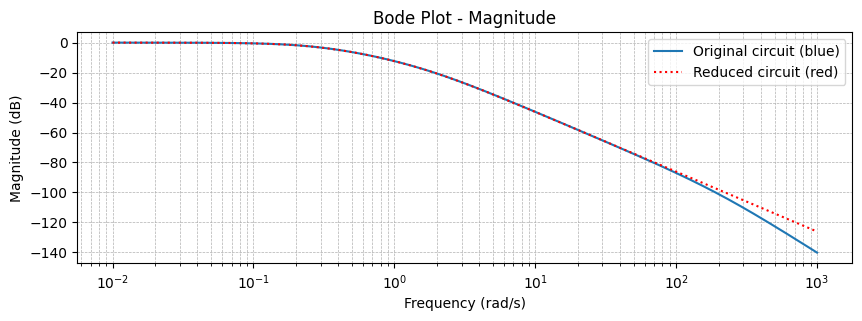

In [196]:
# Plot fT versus Magnitude
#| label: fig-bode-plot-ft-vs-mag
#| fig-cap: Bode plot: Frequency versus Magnitude
plt.figure(figsize=(10, 3))
plt.semilogx(w1, mag1, label='Original circuit (blue)')  # Bode magnitude plot
plt.semilogx(w2, mag2, color='red', linestyle=':', label='Reduced circuit (red)')  # Bode magnitude plot
plt.title('Bode Plot - Magnitude')
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Magnitude (dB)')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

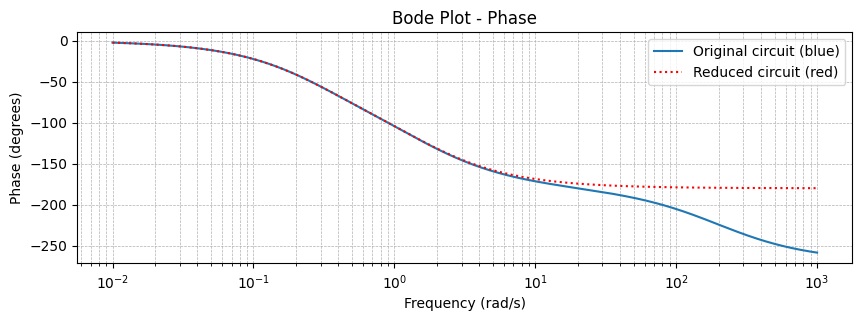

In [197]:
# Plot fT versus phase
#| label: fig-bode-plot-ft-vs-phase
#| fig-cap: Bode plot: Frequency versus Phase
plt.figure(figsize=(10, 3))
plt.semilogx(w1, phase1, label='Original circuit (blue)')  # Bode phase plot
plt.semilogx(w2, phase2, color='red', linestyle=':', label='Reduced circuit (red)')  # Bode phase plot
plt.title('Bode Plot - Phase')
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Phase (degrees)')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

### Pole-Zero plots

In [198]:
import matplotlib.pyplot as plt
import numpy as np

def plot_poles_and_zeros(poles, zeros):
    """
    Plots the poles and zeros of a transfer function on the complex plane.

    Parameters:
    ----------
    poles : list or dict
        A list or dictionary of poles (roots of the denominator). If it's a dictionary,
        the keys are the poles, and the values are their multiplicities.
    zeros : list or dict
        A list or dictionary of zeros (roots of the numerator). If it's a dictionary,
        the keys are the zeros, and the values are their multiplicities.

    Returns:
    -------
    None
    """
    # Convert poles and zeros to lists if they are dictionaries
    if isinstance(poles, dict):
        poles = list(poles.keys())
    if isinstance(zeros, dict):
        zeros = list(zeros.keys())

    # Convert symbolic poles and zeros to Python complex numbers
    poles = [complex(p.evalf()) for p in poles]
    zeros = [complex(z.evalf()) for z in zeros]

    # Separate real and imaginary parts for poles and zeros
    poles_real = [p.real for p in poles]
    poles_imag = [p.imag for p in poles]
    zeros_real = [z.real for z in zeros]
    zeros_imag = [z.imag for z in zeros]

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Horizontal axis
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')  # Vertical axis

    # Plot poles and zeros
    plt.scatter(poles_real, poles_imag, marker='x', color='red', label='Poles', s=100)
    plt.scatter(zeros_real, zeros_imag, marker='o', color='blue', label='Zeros', s=100)

    # Add labels and grid
    plt.title("Pole-Zero Plot")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.axis('equal')  # Equal scaling for real and imaginary axes

    # Show the plot
    plt.show()

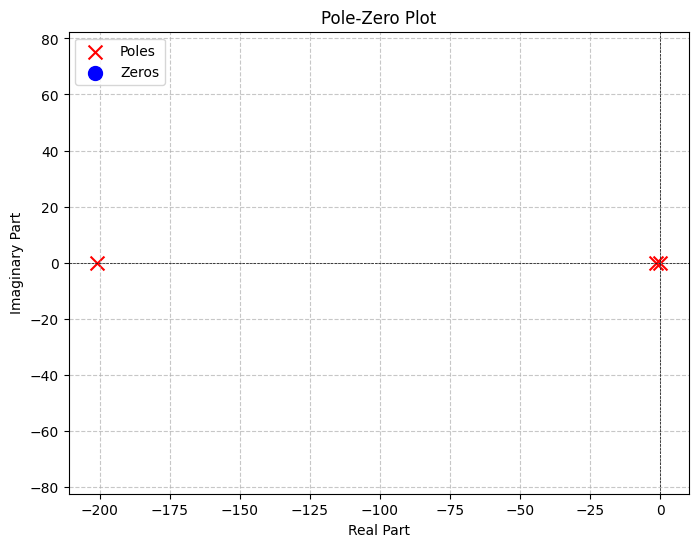

In [199]:
# Pole-Zero Plot for the original circuit
#| label: fig-pole-zero-plot-original
#| fig-cap: Pole-Zero plot: Original circuit

plot_poles_and_zeros(poles=solution_orig['poles'],
                     zeros=solution_orig['zeros'])

If we remove the node at $s=201$ we get better scaling for comparison.

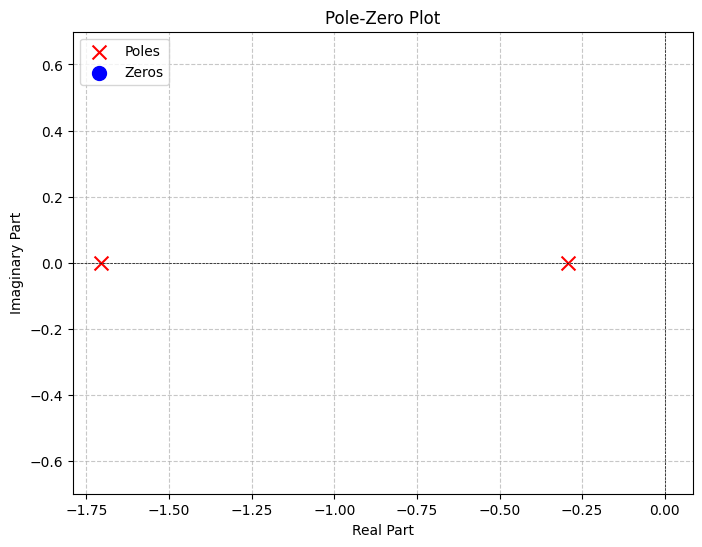

In [204]:
# Pole-Zero Plot for the original circuit (without the pole at s=201)
#| label: fig-pole-zero-plot-original-without-201
#| fig-cap: Pole-Zero plot: Original circuit (without the pole at $s = 201$)
poles = dict(list(solution_orig['poles'].items())[1:])
plot_poles_and_zeros(poles=poles,
                     zeros=solution_orig['zeros'])

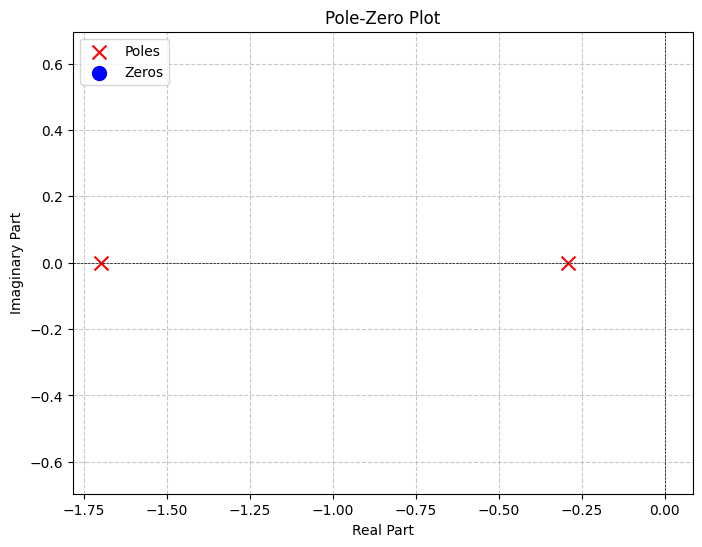

In [200]:
# Pole-Zero Plot for the reduced circuit
#| label: fig-pole-zero-plot-reduced
#| fig-cap: Pole-Zero plot: Reduced circuit

plot_poles_and_zeros(poles=solution_redux['poles'],
                     zeros=solution_redux['zeros'])